# 使用 TEDD 进行可视化

**原作者**: [Yongfeng Gu](https://github.com/yongfeng-nv)

这是关于使用 TEDD (Tensor Expression Debug Display) 可视化张量表达式的介绍。

张量表达式使用原语(primitive)调度。尽管单个原语通常很容易理解，但当您将它们放在一起时，它们很快就变得复杂了。在张量表达式中引入了调度原语的运算模型 (operational model)。

- 不同调度原语之间的交互，
- 调度原语对最终代码生成(code generation)的影响。

运算模型基于数据流图(Dataflow Graph)、调度树(Schedule Tree)和迭代关系图(IterVar Relationship Graph)。调度原语对这些图执行运算。

TEDD 根据给定的调度呈现这三个图。本教程演示了如何使用 TEDD 以及如何解释呈现的图。

In [1]:
import tvm
from tvm import te
from tvm import topi
from tvm.contrib import tedd
from IPython.display import display_svg

## 定义和调度带有 bias 和 ReLU 的卷积

建立包含 Bias 和 ReLU 的卷积张量表达式的例子。首先连接 conv2d、add 和 relu TOPIs。然后，创建 TOPI 通用调度。

In [2]:
batch = 1
in_channel = 256
in_size = 32
num_filter = 256
kernel = 3
stride = 1
padding = "SAME"
dilation = 1

A = te.placeholder((in_size, in_size, in_channel, batch), name="A")
W = te.placeholder((kernel, kernel, in_channel, num_filter), name="W")
B = te.placeholder((1, num_filter, 1), name="bias")

with tvm.target.Target("llvm"):
    t_conv = topi.nn.conv2d_hwcn(A, W, stride, padding, dilation)
    t_bias = topi.add(t_conv, B)
    t_relu = topi.nn.relu(t_bias)
    s = topi.generic.schedule_conv2d_hwcn([t_relu])

## 使用 TEDD 渲染 Graph

渲染图来查看计算过程以及如何调度它。

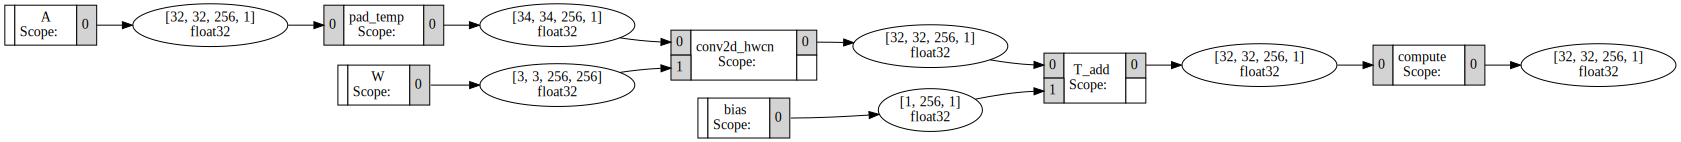

In [3]:
graph = tedd.viz_dataflow_graph(s, show_svg=True)
display_svg(graph)

也可保存图到本地:

```python
tedd.viz_dataflow_graph(s, dot_file_path="/tmp/dfg.dot")
```

第一个是数据流图。每个节点表示一个阶段，中间显示名称和 memory scope，两侧显示 inputs/outputs 信息。边表示节点的依赖关系。

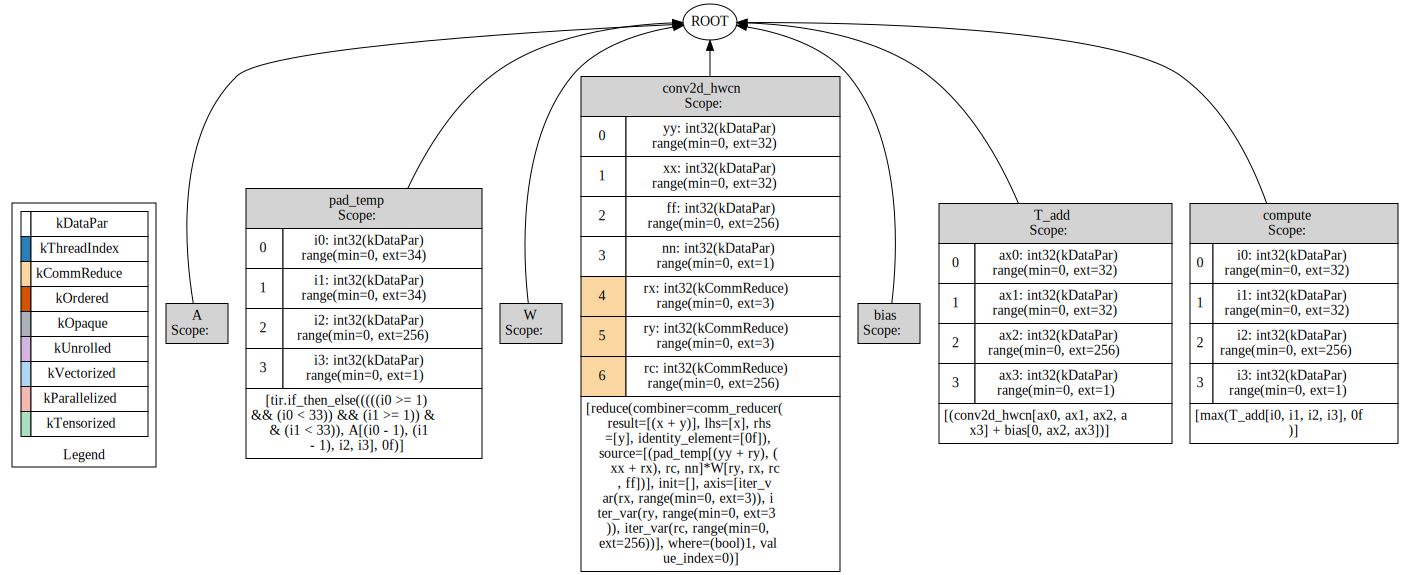

In [4]:
tree = tedd.viz_schedule_tree(s, show_svg=True)
# tedd.viz_schedule_tree(s, dot_file_path="/tmp/scheduletree.dot")
display_svg(tree)

刚刚渲染了调度树图。您可能会注意到关于范围不可用的警告。

该消息还建议调用 `normalize()` 来推断范围信息。鼓励您比较 `normalize()` 前后的图表，以了解其影响。

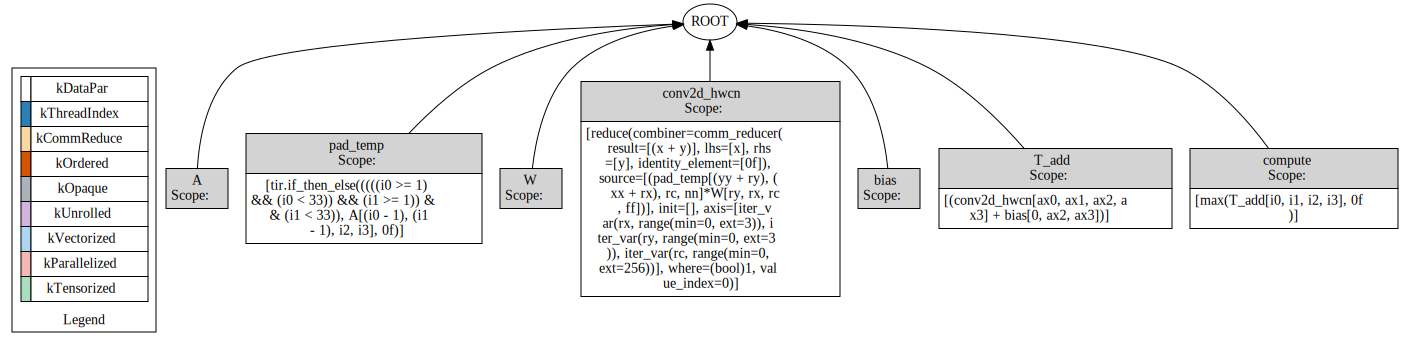

In [5]:
s = s.normalize()
# tedd.viz_schedule_tree(s, dot_file_path="/tmp/scheduletree2.dot")
tree = tedd.viz_schedule_tree(s, show_svg = True)
display_svg(tree)

现在，仔细看看第二个调度树。ROOT 下的每个块代表一个阶段。阶段名称显示在顶部行，计算显示在底部行。中间的行是 IterVars，外部越高，内部越低。

IterVar 行包含它的索引、名称、类型和其他可选信息。以 W.shared 为例。第一行告诉它的名称 "W.shared" 和内存作用域 "Shared"。它的计算是: `W(ax0, ax1, ax2, ax3)`。它最外层的循环 IterVar 是 ax0.ax1.fused.ax2.fused.ax3.fused.outer，kDataPar 的索引为 0，绑定到 threadIdx.y 和 range(min=0, ext=8)。

您还可以使用图例中所示的索引框颜色来告诉 IterVar 类型。

如果一个阶段没有 compute_at 的任何其他阶段，它就有一条直接到 ROOT 节点的边。否则，它有一条边指向它所附加的 IterVar，例如 W.shared  附加到 rx.outer 中间计算阶段。

```{note}
:class: alert alert-info

根据定义，itervar 是内部节点，计算是调度树的叶子节点。省略了 IterVars 之间的边和阶段内的计算，使每个阶段成为块，以提高可读性。
```

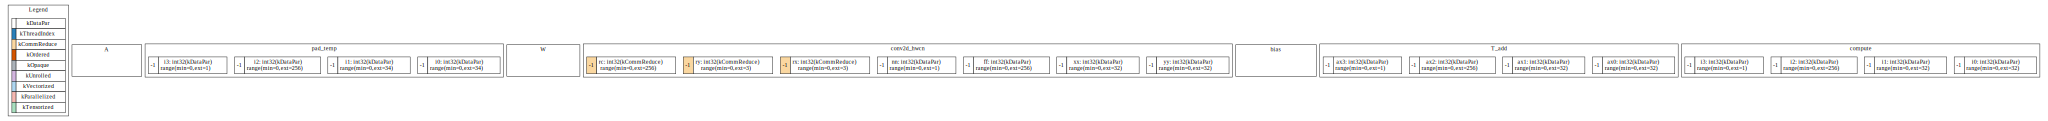

In [6]:
from graphviz import Source
# tedd.viz_itervar_relationship_graph(s, dot_file_path="/tmp/itervar.dot")
dot_string = tedd.viz_itervar_relationship_graph(s, output_dot_string=True)
src = Source(dot_string)
display_svg(src)

最后一个是迭代关系图(IterVar Relationship Graph)。每个子图表示一个阶段，并包含 IterVar 节点和变换节点。例如，W.shared 有三个 split 节点和三个 fuse 节点。其余的是 IterVar 节点，其格式与 Schedule Trees 中的 IterVar 行相同。Root itervar 是那些不受任何变换节点驱动的迭代器，例如 ax0; 叶 IterVars 不驱动任何变换节点，并且具有非负索引，如 ax0.ax1.fused.ax2.fused.ax3.fused.outer 索引为 0。

## 小结

本教程演示了 TEDD 的用法。使用一个用 TOPI 构建的示例来显示底层的调度。您还可以在任何调度原语之前和之后使用它来检查其效果。